In [19]:
import os, sys

from ogb.linkproppred import PygLinkPropPredDataset, Evaluator
import torch 

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from matplotlib import pyplot as plt
import random 
from tqdm import tqdm 
import numpy as np 
from visual import find_optimal_threshold, get_metric_invariant


MRR: 0.50


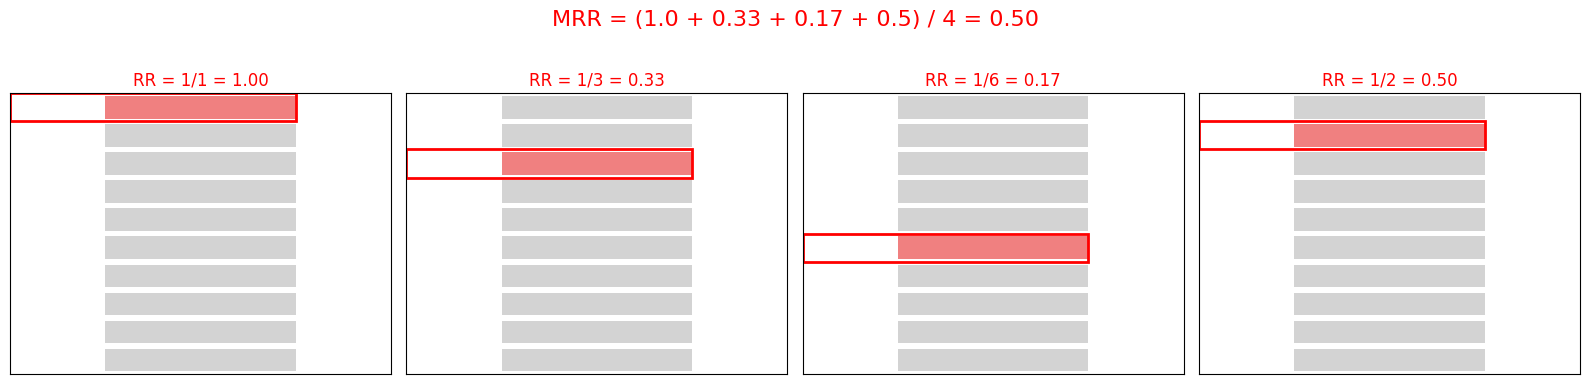

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Example relevance data for 4 queries
relevance_data = [
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # RR = 1/1 = 1
    [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],  # RR = 1/3 = 0.33
    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],  # RR = 1/6 = 0.17
    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],  # RR = 1/2 = 0.5
]

# Calculate RR and MRR
reciprocal_ranks = []
for relevance in relevance_data:
    try:
        first_relevant_index = relevance.index(1)
        rr = 1 / (first_relevant_index + 1)
    except ValueError:
        rr = 0
    reciprocal_ranks.append(rr)

mrr = np.mean(reciprocal_ranks)
print(f"MRR: {mrr:.2f}")

# Visualization
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

for i, (ax, relevance, rr) in enumerate(zip(axes, relevance_data, reciprocal_ranks)):
    colors = ['lightcoral' if x == 1 else 'lightgrey' for x in relevance]
    ax.barh(range(1, 11), [1] * 10, color=colors, edgecolor='none')
    first_relevant_index = relevance.index(1)
    ax.add_patch(plt.Rectangle((-0.5, first_relevant_index + 0.5), 1.5, 1, fill=None, edgecolor='red', lw=2))
    ax.set_xlim(-0.5, 1.5)
    ax.set_ylim(10.5, 0.5)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'RR = 1/{first_relevant_index + 1} = {rr:.2f}', fontsize=12, color='red')

fig.suptitle(f'MRR = ({ " + ".join([str(round(rr, 2)) for rr in reciprocal_ranks]) }) / 4 = {mrr:.2f}', fontsize=16, color='red')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Test 1: Neg and Pos follow the gaussian distribution with different mean and variance

\begin{equation}
P1 \sim \mathcal{N}(\mu_{\text{pos}}, \sigma_{\text{pos}}^2) \quad P2 \sim \mathcal{N}(\mu_{\text{neg}}, \sigma_{\text{neg}}^2) 
\end{equation}

\begin{equation}
P(x | H_1) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp( -\frac{(x - 1)^2}{2\sigma^2} ) 
\end{equation}

\begin{equation}
P(x | H_0) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp( -\frac{(x + 1)^2}{2\sigma^2})
\end{equation}

\begin{equation}
P(H_1 | x) = \frac{P(x | H_1) P(H_1)}{P(x)}, \text{prior}: P(H_1), \quad \text{data dist}: P(x), \quad \text{likelihood}: P(x | H_1) P(H_1)
\end{equation}

$$
\text{Decision based on MAP} = \begin{cases}
H_0 & \text{if } P(H_0 \mid x) > P(H_1 \mid x) \\
H_1 & \text{if } P(H_1 \mid x) > P(H_0 \mid x)
\end{cases}
$$


| ![Image 1](map_binary.png) | ![Image 2](plot_unequal_priors_intersection.png) |
| --------------------- | --------------------- |
| Two Ns with the same prior| Two Ns with different priors  |

\begin{equation}
\text{Optimal threshold minimized Jorden Statistic} \quad x \gtrless \frac{\sigma^2}{2} \ln \left( \frac{P(H_0)}{P(H_1)} \right) + \frac{1}{2} 
\end{equation}

20it [00:00, 30.99it/s]
20it [00:00, 31.83it/s]


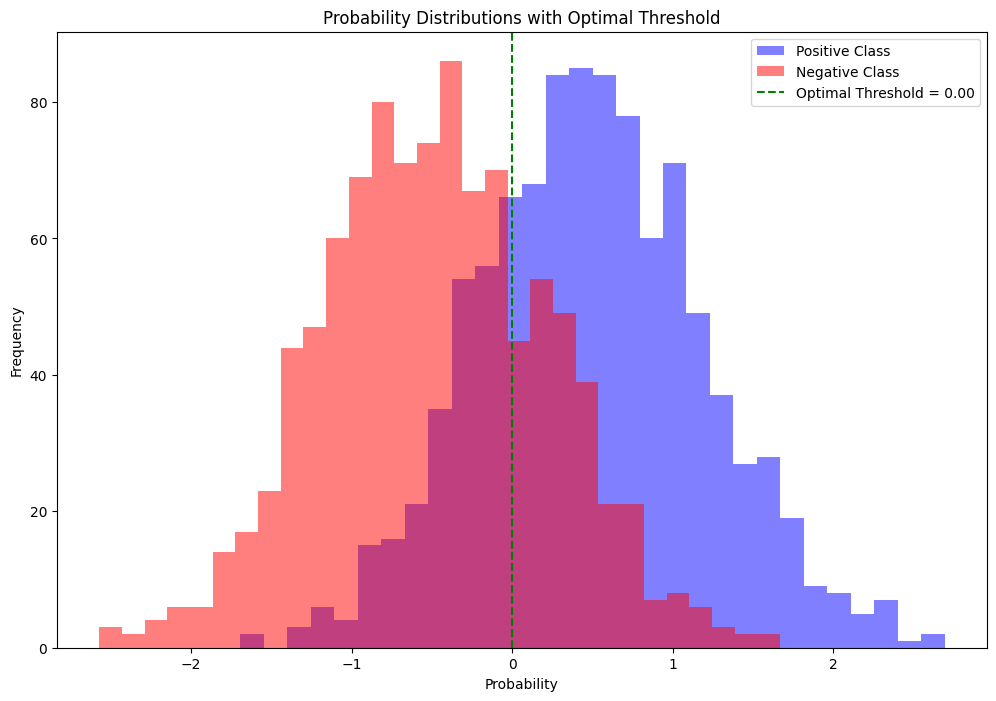

<Figure size 640x480 with 0 Axes>

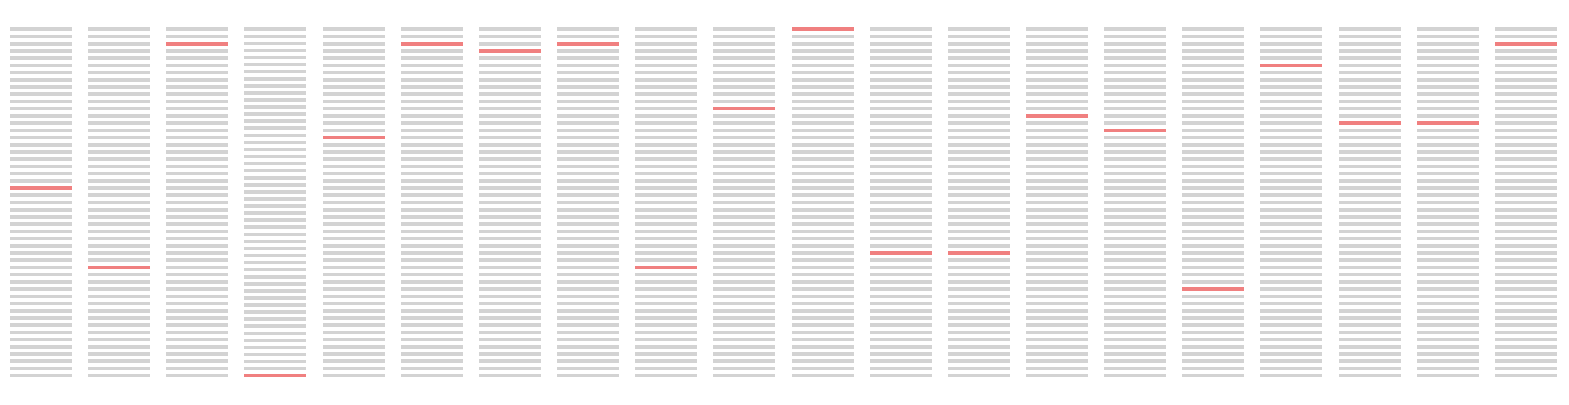

<Figure size 640x480 with 0 Axes>

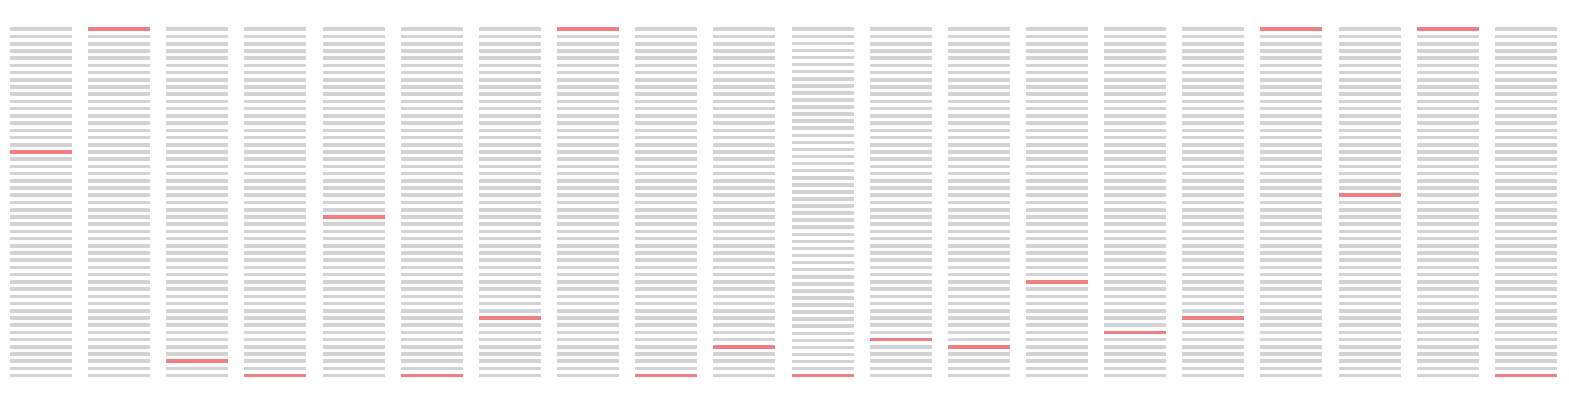

In [22]:
# evaluator = Evaluator(name='ogbl-collab')
evaluator_hit = Evaluator(name='ogbl-collab')
evaluator_mrr = Evaluator(name='ogbl-citation2')

mean_pos, var_pos = 0.5, 0.5  # Mean and variance for positive class 
mean_neg, var_neg = -0.5, 0.5  # Mean and variance for negative class
size = 1000  # Number of samples in each class

P1 = np.random.normal(loc=mean_pos, scale=np.sqrt(var_pos), size=size)
P2 = np.random.normal(loc=mean_neg, scale=np.sqrt(var_neg), size=size)
pos_index = np.random.randint(low=0, high=size-1, size=(size, 2)) 
neg_index = np.random.randint(low=0, high=size-1, size=(size, 2)) 

plt.figure(figsize=(12, 8))

# Plot distributions of probabilities
plt.hist(P1, bins=30, alpha=0.5, color='blue', label='Positive Class')
plt.hist(P2, bins=30, alpha=0.5, color='red', label='Negative Class')
best_threshold, best_accuracy= find_optimal_threshold(P1, P2)

plt.axvline(best_threshold, color='green', linestyle='--', label=f'Optimal Threshold = {best_threshold:.2f}')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.legend()
plt.title('Probability Distributions with Optimal Threshold')
plt.savefig('optimal_threshold.png')
P1 = torch.tensor(P1)
P2 = torch.tensor(P2)
# result = get_metric_score(evaluator_hit, evaluator_mrr, P1, P2)


k_list  = [0.1, 0.2, 0.3, 0.5, 1]
mrr_pos2neg, mrr_neg2pos, result_auc_test, pos_edge_index_err, pos_rank_err, neg_edge_index_err, neg_rank_err = get_metric_invariant(P1, pos_index, P2, neg_index, k_list)

In [23]:
mrr_pos2neg, mrr_neg2pos

({'mrr_hit0.1': tensor(0.5350),
  'mrr_hit0.2': tensor(0.6800),
  'mrr_hit0.3': tensor(0.8000),
  'mrr_hit0.5': tensor(0.9280),
  'mrr_hit1.0': tensor(1.)},
 {'mrr_hit100': tensor(0.0040),
  'mrr_hit200': tensor(0.0140),
  'mrr_hit300': tensor(0.0280),
  'mrr_hit500': tensor(0.0890),
  'mrr_hit1000': tensor(1.)})

In [24]:
result_auc_test

{'AUC': 0.8344, 'AP': 0.8304}

In [25]:
pos_edge_index_err

array([[279, 983],
       [753, 151],
       [658, 550],
       [700, 536],
       [755, 734],
       [229, 664],
       [922, 287],
       [394, 452],
       [619,  32],
       [914, 362],
       [110, 120],
       [ 15, 738],
       [522, 714],
       [713,  97],
       [115, 964],
       [470, 438],
       [280, 348],
       [231, 972],
       [110, 351],
       [929,  11],
       [983, 487],
       [532, 638],
       [284, 946],
       [632, 635],
       [918, 544],
       [391, 169],
       [ 76, 964],
       [296, 329],
       [ 62, 269],
       [215, 189],
       [ 74, 685],
       [509, 578],
       [ 92,  52],
       [495, 947],
       [ 93, 624],
       [228, 249],
       [390, 720],
       [979, 181],
       [266, 280],
       [954, 983],
       [961, 666],
       [ 82, 185],
       [860, 996],
       [650, 566],
       [530, 347],
       [422, 980],
       [857, 981],
       [453, 266],
       [506, 141],
       [315, 675],
       [763, 231],
       [296, 897],
       [952,

In [26]:
pos_rank_err

array([ 45,  15, 539,   3,  49,  14, 449,  21, 590, 330,  49, 139,  77,
         1,  79,  20,  94,  99, 340,  40,   1,  67, 137,   8,   9,  32,
       146,   8,  60,  13, 284, 221,  67, 436, 164, 450, 555,   1, 225,
       204,  68, 371, 199,   1,  41,  10,   2,  54, 127, 507, 170, 114,
       280,   2,   8,  10, 105, 357,   4,  45,  17,  23,  46,   1, 236,
       146,   2,  68, 107, 134,  21, 128, 156,  22,  67, 349,  76,   3,
        18,   3, 255,   8, 232, 434, 279,  60,   9,  46, 111, 356,  20,
        11,  47, 365,  15,   7,   2])

In [27]:
neg_edge_index_err

array([[678, 403],
       [ 76, 995],
       [236, 707],
       [290, 135],
       [819, 807],
       [888, 880],
       [366, 547],
       [901, 247],
       [765, 213],
       [763,  69],
       [745, 995],
       [328,  15],
       [486, 173],
       [698, 805],
       [736, 273],
       [523, 821],
       [218, 942],
       [512, 398],
       [110, 986],
       [463, 788],
       [640,  92],
       [450, 395],
       [891, 923],
       [550, 932],
       [478, 315],
       [670, 697],
       [992, 352],
       [767, 238],
       [103, 906],
       [877,  28],
       [ 88, 374],
       [396, 562],
       [363, 949],
       [146, 313],
       [547, 795],
       [451, 898],
       [505, 485],
       [100, 106],
       [856, 936],
       [290, 348],
       [616, 732],
       [587, 226],
       [595, 976],
       [587, 760],
       [766,  49],
       [867, 969],
       [721, 157],
       [327, 744],
       [882,  76],
       [734, 632],
       [453, 309],
       [326, 507],
       [852,

In [28]:
neg_rank_err 

array([900, 978, 987, 986, 933, 787, 933, 943, 999, 692, 933, 968, 870,
       987, 967, 909, 984, 998, 999, 822, 932, 935, 996, 931, 965, 982,
       936, 859, 343, 793, 694, 614, 986, 958, 990, 984, 967, 984, 880,
       831, 997, 957, 956, 997, 986, 691, 694, 998, 814, 997, 965, 939,
       734, 943, 994, 996, 898, 984, 966, 659, 830, 409, 994, 984, 890,
       322, 986, 922, 526, 917, 649, 282, 859, 821, 737, 990, 997, 899,
       983, 632, 858, 640, 996, 653, 999, 994, 772, 976, 966, 909, 480,
       999, 555, 536])